<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 02 - Classification and Clustering

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

In [1]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br> 
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [3]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### NLTK Downloads

In [4]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [5]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [6]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [8]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = stopwords.words('english')
    #tokens = [w for w in tokens if not w in stop_words]    
    ## add new stop words
    new_words = ['movie','story', 'film', 'movies', 'films']
    stop_words.extend(new_words)
    all_stop_words = set(stop_words)
    tokens = [w for w in tokens if not w in all_stop_words]

    ## lemmatize words
    lemmatizer = WordNetLemmatizer()     
    tokens = [lemmatizer.lemmatize(w) for w in tokens]  

    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

## Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix 
1. Latent Semantic Analysis 
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [9]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
            
def create_gensim_lda_model(doc_clean, number_of_topics, words, iterations):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, iterations = iterations)
    # train model
    print(ldamodel.print_topics(num_topics = number_of_topics, num_words = words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)
    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest

In [10]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame

def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    return accy

## Visualization Utility Functions

In [11]:
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(35, 15))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90, fontsize = 6);
    plt.yticks(range(len(processed_text)), titles, fontsize = 6);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [12]:
#read in class corpus csv into python
work_dir = "/content/gdrive/My Drive/MSDS 453/Week 2/Assignment 1/"
data = get_corpus_df(work_dir + 'ClassCorpus_v2.csv')

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploratory Data Analysis

In [13]:
CORPUS_PATH = "/content/gdrive/My Drive/MSDS 453/Week 2/Assignment 1/"
corpus_df = get_corpus_df(work_dir + 'ClassCorpus_v2.csv')
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [14]:
corpus_df.shape

(200, 8)

In [15]:
corpus_df.head()

DSI_Title Student Name Genre of Movie  \
Doc_ID                                                               
191     JLU_Doc1_JamesBondCasinoRoyale          JLU         Action   
192     JLU_Doc2_JamesBondCasinoRoyale          JLU         Action   
193     JLU_Doc3_JamesBondCasinoRoyale          JLU         Action   
194     JLU_Doc4_JamesBondCasinoRoyale          JLU         Action   
195     JLU_Doc5_JamesBondCasinoRoyale          JLU         Action   

       Review Type (pos or neg)                Movie Title  \
Doc_ID                                                       
191                    Negative  James Bond, Casino Royale   
192                    Negative  James Bond, Casino Royale   
193                    Negative  James Bond, Casino Royale   
194                    Negative  James Bond, Casino Royale   
195                    Negative  James Bond, Casino Royale   

                                                     Text  \
Doc_ID                                                      
191     Is this where we are at? Is this the state of ...   
192     Give or take the odd Octopussy, I suppose, lik...   
193     The James Bond films have been with us for mor...   
194     The introduction of a new James Bond always br...   
195     Although box office has remained strong worldw...   

                                    Descriptor  Doc_ID  
Doc_ID                                                  
191     Action_James Bond, Casino Royale_N_191     191  
192     Action_James Bond, Casino Royale_N_192     192  
193     Action_James Bond, Casino Royale_N_193     193  
194     Action_James Bond, Casino Royale_N_194     194  
195     Action_James Bond, Casino Royale_N_195     195

In [16]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 191 to 75
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Student Name              200 non-null    object
 2   Genre of Movie            200 non-null    object
 3   Review Type (pos or neg)  200 non-null    object
 4   Movie Title               200 non-null    object
 5   Text                      200 non-null    object
 6   Descriptor                200 non-null    object
 7   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 14.1+ KB
None


In [17]:
tfidf_matrix, tfidf_words = tfidf(final_processed_text, titles, ngram_range = (1,1))
#tfidf_matrix

## Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest

## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [18]:
cluster_title, clusters, k_means_df = k_means(titles, tfidf_matrix, k = 20)

In [19]:
cluster_title[3]

['DLJ_Doc6_Hereditary',
 'DLJ_Doc7_Hereditary',
 'DLJ_Doc8_Hereditary',
 'DLJ_Doc9_Hereditary',
 'DLJ_Doc10_Hereditary',
 'DLJ_Doc1_Hereditary',
 'DLJ_Doc2_Hereditary',
 'DLJ_Doc3_Hereditary',
 'DLJ_Doc4_Hereditary',
 'DLJ_Doc5_Hereditary']

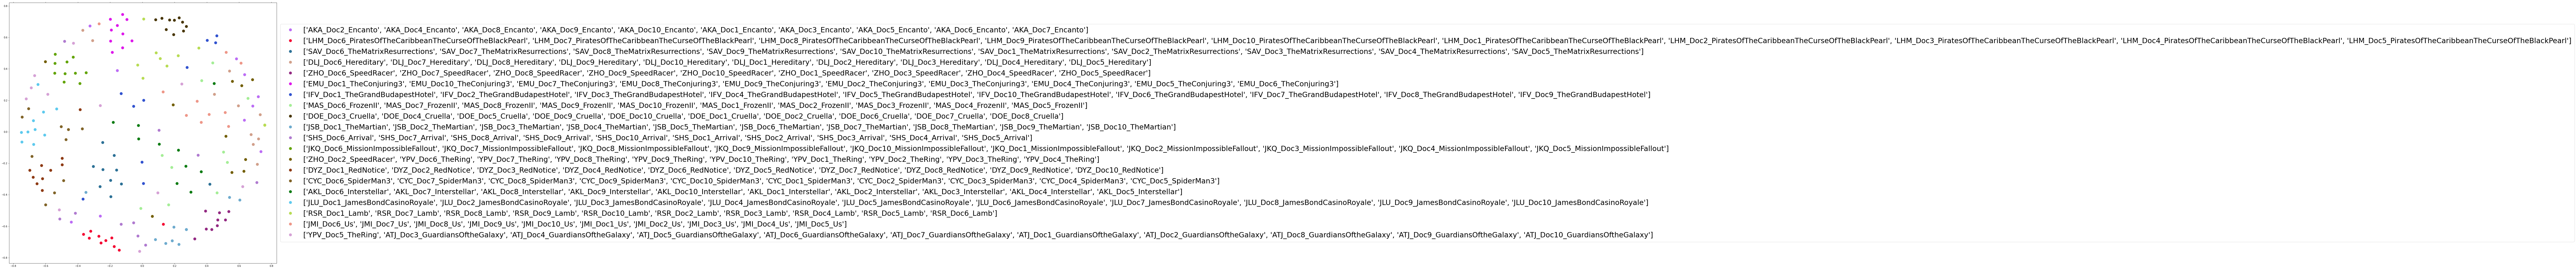

In [20]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Implementation of Silhouette Score - optimal number of clusters

In [21]:
cluster_title, clusters, k_means_df = k_means(titles, tfidf_matrix, k = 20)

In [22]:
## k_list = [3, 4, 5, 7, 9 ,11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33]
k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

#silhoutte score list
k_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state = 30)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    k_scores.append(score)
    print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.013
Silhouette Score: 0.023
Silhouette Score: 0.023
Silhouette Score: 0.030
Silhouette Score: 0.040
Silhouette Score: 0.044
Silhouette Score: 0.053
Silhouette Score: 0.052
Silhouette Score: 0.061
Silhouette Score: 0.071
Silhouette Score: 0.077
Silhouette Score: 0.077
Silhouette Score: 0.079
Silhouette Score: 0.090
Silhouette Score: 0.094
Silhouette Score: 0.097
Silhouette Score: 0.102
Silhouette Score: 0.099
Silhouette Score: 0.099
Silhouette Score: 0.107
Silhouette Score: 0.104
Silhouette Score: 0.108
Silhouette Score: 0.103
Silhouette Score: 0.107
Silhouette Score: 0.104
Silhouette Score: 0.104
Silhouette Score: 0.092
Silhouette Score: 0.106
Silhouette Score: 0.094


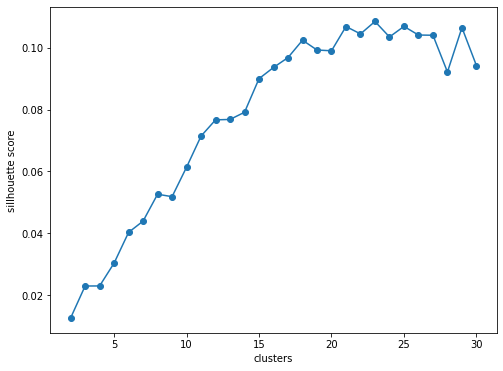

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(k_list, k_scores)
plt.plot(k_list, k_scores)
plt.xlabel("clusters")
plt.ylabel("sillhouette score")
plt.show()

### Generate TF-IDF For Analysis

In [24]:
tfidf_matrix, terms = tfidf(final_processed_text, titles)

In [25]:
#############################################
#Performs the k-means clustering of the tfidf matrix
#Edit the number of clusters
#############################################
def k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k = 10):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    km = KMeans(n_clusters=k, random_state = 30)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]


    #save the terms for each cluster and document to dictionaries.  To be used later
    #for plotting output.

    #dictionary to store terms and titles
    cluster_terms={}
    cluster_title={}


    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
        cluster_terms[i]=temp_terms

        print("Cluster %d titles:" % i, end='')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            print(' %s,' % title, end='')
            temp_titles.append(title)
        cluster_title[i]=temp_titles

In [26]:
k_means_tfidf(tfidf_matrix, terms, titles, final_processed_text, k = 17)

Top terms per cluster:
Cluster 0:
 mirabel
 frozen
 family
 encanto
 disney
 madrigal
 power
 magical
 song
 kristoff
Cluster 0 titles: AKA_Doc4_Encanto, AKA_Doc8_Encanto, AKA_Doc9_Encanto, AKA_Doc10_Encanto, AKA_Doc1_Encanto, AKA_Doc3_Encanto, AKA_Doc5_Encanto, AKA_Doc6_Encanto, AKA_Doc7_Encanto, MAS_Doc6_FrozenII, MAS_Doc7_FrozenII, MAS_Doc8_FrozenII, MAS_Doc9_FrozenII, MAS_Doc10_FrozenII, MAS_Doc1_FrozenII, MAS_Doc2_FrozenII, MAS_Doc3_FrozenII, MAS_Doc4_FrozenII, MAS_Doc5_FrozenII,Cluster 1:
 annie
 ingvar
 hereditary
 family
 horror
 maria
 aster
 sheep
 rapace
 jóhannsson
Cluster 1 titles: ZHO_Doc2_SpeedRacer, AKA_Doc2_Encanto, DLJ_Doc6_Hereditary, DLJ_Doc7_Hereditary, DLJ_Doc8_Hereditary, DLJ_Doc9_Hereditary, DLJ_Doc10_Hereditary, DLJ_Doc1_Hereditary, DLJ_Doc2_Hereditary, DLJ_Doc3_Hereditary, DLJ_Doc4_Hereditary, DLJ_Doc5_Hereditary, RSR_Doc1_Lamb, RSR_Doc7_Lamb, RSR_Doc8_Lamb, RSR_Doc9_Lamb, RSR_Doc10_Lamb, RSR_Doc2_Lamb, RSR_Doc3_Lamb, RSR_Doc4_Lamb, RSR_Doc5_Lamb, RSR_Doc6_Lam

### Doc2Vec

In [27]:
def doc2vec_with_titles(corpus, processed_text, titles, vector_size = 300):
    #function to created doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    model = Doc2Vec(documents, vector_size=300, window=3, min_count=2, workers=4)

    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

    doc2vec_df=doc2vec_df.reset_index()

    doc_titles={'title': titles}
    t=pd.DataFrame(doc_titles)

    doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

    doc2vec_df=doc2vec_df.drop('index', axis=1)
    return doc2vec_df

def k_means_doc2vec(doc2vec_df, final_processed_text,titles, k = 5):
    
    #this is a funciton to create the k_means outputs using the doc2vec matrics.  Required inputs
    #include the doc2vec matrix, and desired number of clusters.
    doc2vec_k_means=doc2vec_df.drop('title', axis=1)

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(doc2vec_k_means)

    clusters_d2v = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        print("Cluster %d:" % i)
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            print(' %s ' % title, end='\n')
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list
    
doc2vec_model = doc2vec_with_titles(final_processed_text, processed_text,titles)
doc2vec_model.index = titles
k_means_doc2vec(doc2vec_model, final_processed_text,titles, k = 4)

Cluster 0:
 JLU_Doc2_JamesBondCasinoRoyale 
 JLU_Doc9_JamesBondCasinoRoyale 
 JKQ_Doc6_MissionImpossibleFallout 
 JKQ_Doc5_MissionImpossibleFallout 
 LHM_Doc6_PiratesOfTheCaribbeanTheCurseOfTheBlackPearl 
 LHM_Doc7_PiratesOfTheCaribbeanTheCurseOfTheBlackPearl 
 LHM_Doc10_PiratesOfTheCaribbeanTheCurseOfTheBlackPearl 
 LHM_Doc5_PiratesOfTheCaribbeanTheCurseOfTheBlackPearl 
 ZHO_Doc7_SpeedRacer 
 ZHO_Doc8_SpeedRacer 
 ZHO_Doc5_SpeedRacer 
 DOE_Doc3_Cruella 
 DOE_Doc4_Cruella 
 DOE_Doc9_Cruella 
 DOE_Doc2_Cruella 
 DOE_Doc6_Cruella 
 DOE_Doc7_Cruella 
 AKA_Doc10_Encanto 
 AKA_Doc3_Encanto 
 AKA_Doc6_Encanto 
 MAS_Doc7_FrozenII 
 DYZ_Doc1_RedNotice 
 DYZ_Doc2_RedNotice 
 DYZ_Doc9_RedNotice 
 DYZ_Doc10_RedNotice 
 CYC_Doc7_SpiderMan3 
 CYC_Doc3_SpiderMan3 
 IFV_Doc2_TheGrandBudapestHotel 
 IFV_Doc8_TheGrandBudapestHotel 
 DLJ_Doc6_Hereditary 
 DLJ_Doc8_Hereditary 
 DLJ_Doc9_Hereditary 
 DLJ_Doc10_Hereditary 
 DLJ_Doc1_Hereditary 
 RSR_Doc1_Lamb 
 EMU_Doc10_TheConjuring3 
 EMU_Doc7_TheConjuri

In [28]:
print(doc2vec_model)

                                        0         1         2         3  \
JLU_Doc1_JamesBondCasinoRoyale  -0.000466  0.001418  0.000939  0.000701   
JLU_Doc2_JamesBondCasinoRoyale  -0.000087  0.001116 -0.001269 -0.000244   
JLU_Doc3_JamesBondCasinoRoyale  -0.000625  0.000004  0.001124 -0.000693   
JLU_Doc4_JamesBondCasinoRoyale  -0.000396 -0.000783  0.000805 -0.001042   
JLU_Doc5_JamesBondCasinoRoyale  -0.000065  0.001069 -0.000474 -0.000480   
...                                   ...       ...       ...       ...   
SAV_Doc1_TheMatrixResurrections  0.001121 -0.001503  0.000572  0.000285   
SAV_Doc2_TheMatrixResurrections  0.000644  0.001391  0.001048  0.000021   
SAV_Doc3_TheMatrixResurrections  0.001116  0.000171 -0.001241  0.000025   
SAV_Doc4_TheMatrixResurrections  0.001321 -0.000305  0.001660  0.000443   
SAV_Doc5_TheMatrixResurrections  0.000153  0.000029 -0.000474 -0.001288   

                                        4         5         6         7  \
JLU_Doc1_JamesBondCasino

### Generate Labels for Supervised Learning Models

In [29]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
191    0
192    0
193    0
194    0
195    0
      ..
71     1
72     1
73     1
74     1
75     1
Name: Review Type (pos or neg), Length: 200, dtype: int64


### Support Vector Machines 

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br> 
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [30]:
classifiers(tfidf_matrix, labels, 'svm')

svm


0.3787878787878788

### Logistic Regression Model 

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [31]:
classifiers(tfidf_matrix, labels, 'logistic')

logistic


0.3787878787878788

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br> 
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [32]:
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


0.36363636363636365

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [33]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


0.3484848484848485

## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 topics and 10 words

[(0, '0.247*"character" + 0.163*"cruella" + 0.155*"first" + 0.133*"scene" + 0.130*"would" + 0.128*"world" + 0.128*"action" + 0.125*"never" + 0.121*"anderson" + 0.114*"thing"'), (1, '0.751*"cruella" + 0.163*"estella" + 0.159*"baroness" + 0.148*"stone" + -0.137*"anderson" + 0.123*"fashion" + 0.123*"thompson" + 0.111*"villain" + 0.090*"character" + -0.090*"matrix"')]


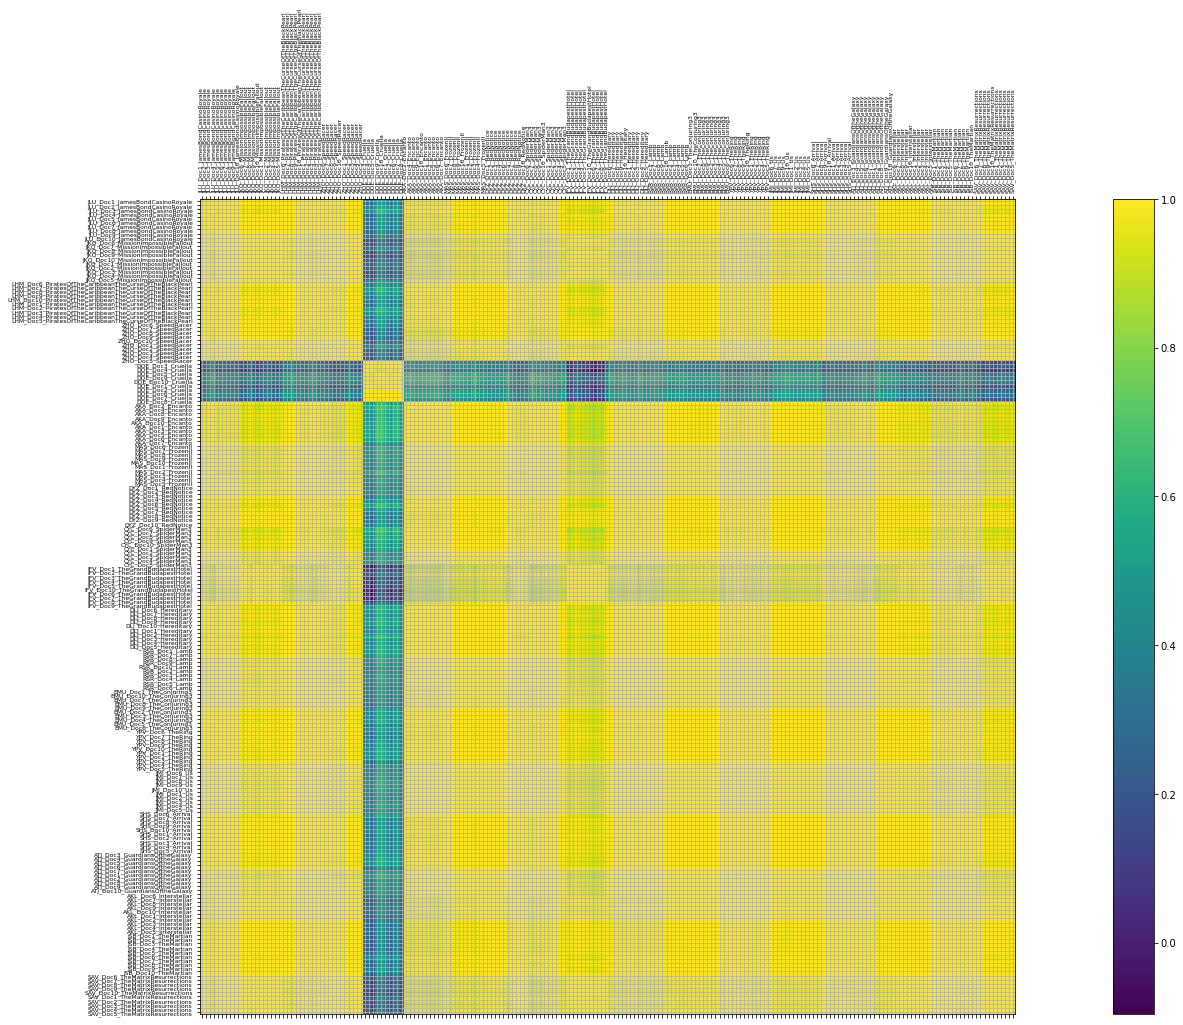

In [34]:
model_2topic_10words = plot_lsa(2, 10)


### Test: 4 topics 10 words

[(0, '0.247*"character" + 0.163*"cruella" + 0.155*"first" + 0.133*"scene" + 0.130*"would" + 0.128*"world" + 0.128*"action" + 0.125*"never" + 0.121*"anderson" + 0.114*"thing"'), (1, '-0.751*"cruella" + -0.163*"estella" + -0.159*"baroness" + -0.148*"stone" + 0.137*"anderson" + -0.123*"fashion" + -0.123*"thompson" + -0.110*"villain" + -0.090*"character" + 0.090*"matrix"'), (2, '0.477*"anderson" + 0.292*"budapest" + 0.285*"grand" + 0.276*"hotel" + 0.202*"gustave" + -0.164*"mission" + 0.153*"andersonõs" + -0.131*"action" + -0.120*"impossible" + -0.114*"cruise"'), (3, '0.287*"mission" + 0.260*"impossible" + 0.254*"cruise" + 0.228*"action" + 0.224*"fallout" + -0.223*"family" + 0.222*"matrix" + -0.166*"horror" + 0.149*"mcquarrie" + 0.126*"anderson"')]


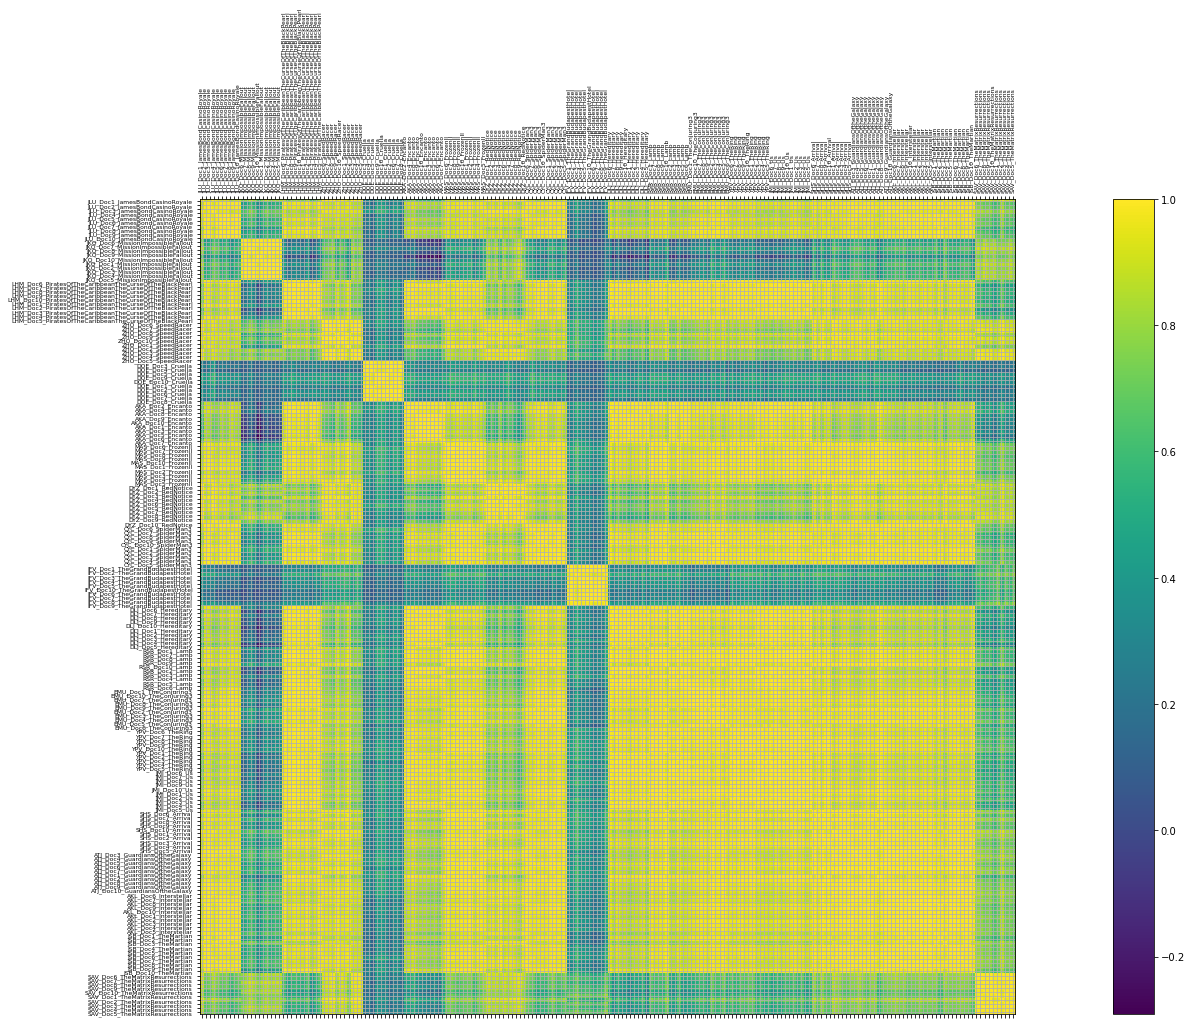

In [35]:
model_4topic_10words = plot_lsa(4, 10)

#/content/gdrive/My Drive/MSDS 453/Week 2/Assignment 1/

#plt.savefig(f’/content/gdrive/MyDrive/figures/model_10topic_20words_lsa.png’)
#plt.savefig(f’/content/gdrive/MyDrive/figures/model_4topic_5words_lda.png’)

### Plotting 6 topics and 10 words

[(0, '0.247*"character" + 0.163*"cruella" + 0.155*"first" + 0.133*"scene" + 0.130*"would" + 0.128*"world" + 0.128*"action" + 0.125*"never" + 0.121*"anderson" + 0.114*"thing"'), (1, '0.751*"cruella" + 0.163*"estella" + 0.159*"baroness" + 0.148*"stone" + -0.137*"anderson" + 0.123*"fashion" + 0.123*"thompson" + 0.111*"villain" + 0.090*"character" + -0.090*"matrix"'), (2, '0.478*"anderson" + 0.292*"budapest" + 0.285*"grand" + 0.276*"hotel" + 0.202*"gustave" + -0.164*"mission" + 0.152*"andersonõs" + -0.131*"action" + -0.120*"impossible" + -0.114*"cruise"'), (3, '-0.287*"mission" + -0.260*"impossible" + -0.255*"cruise" + -0.228*"action" + -0.224*"fallout" + 0.223*"family" + -0.222*"matrix" + 0.166*"horror" + -0.149*"mcquarrie" + -0.126*"anderson"'), (4, '0.496*"matrix" + 0.226*"speed" + 0.215*"resurrection" + -0.200*"casino" + -0.200*"royale" + -0.194*"vesper" + 0.168*"wachowski" + 0.167*"racer" + -0.153*"mission" + -0.118*"impossible"'), (5, '0.327*"casino" + 0.323*"royale" + 0.300*"vesper"

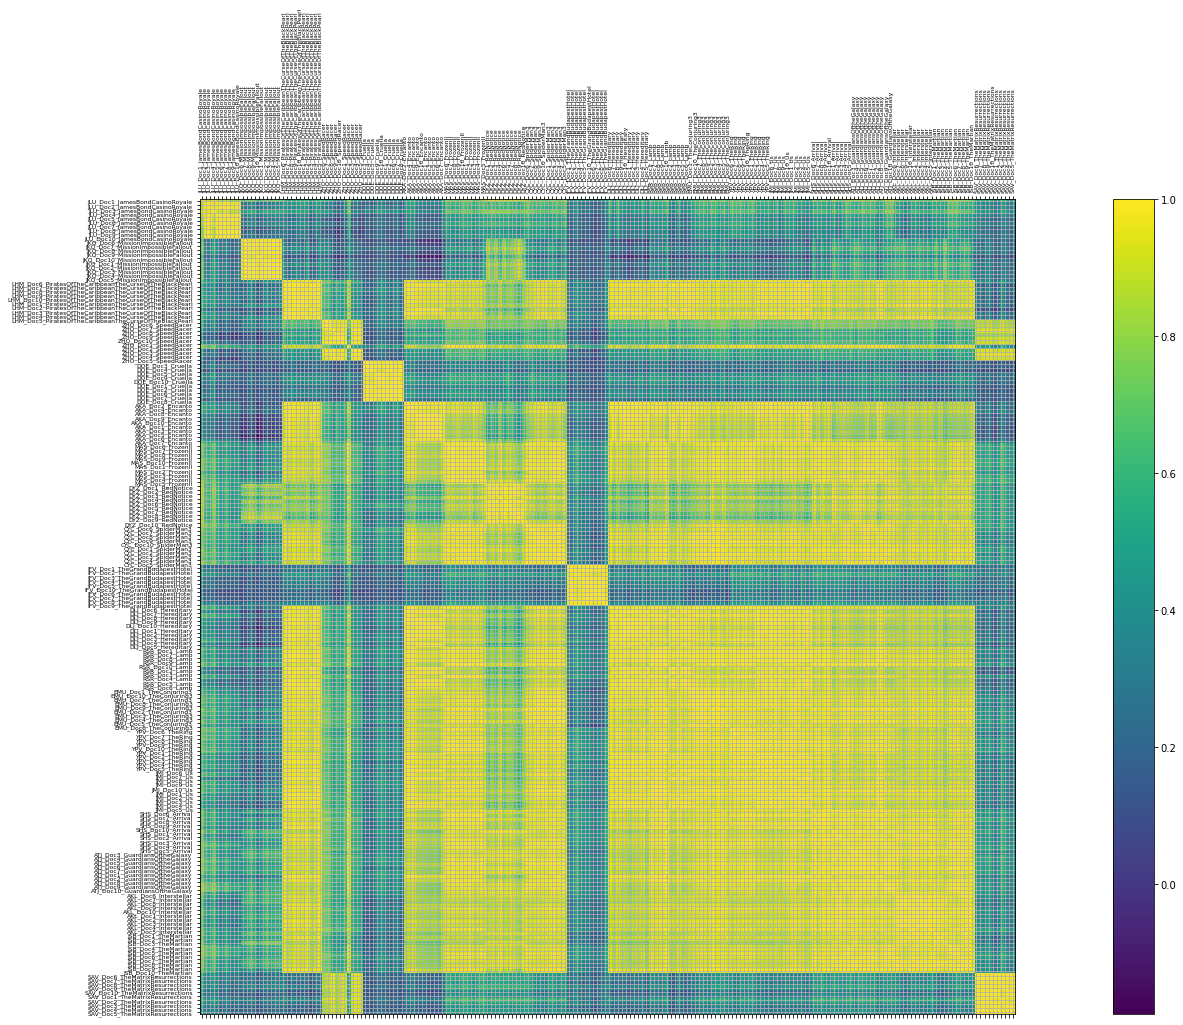

In [36]:
model_6topic_10words = plot_lsa(6, 10)

### Test: 8 topics 10 words

[(0, '0.247*"character" + 0.163*"cruella" + 0.155*"first" + 0.133*"scene" + 0.130*"would" + 0.128*"world" + 0.128*"action" + 0.125*"never" + 0.121*"anderson" + 0.114*"thing"'), (1, '0.751*"cruella" + 0.163*"estella" + 0.159*"baroness" + 0.148*"stone" + -0.137*"anderson" + 0.123*"fashion" + 0.123*"thompson" + 0.110*"villain" + 0.090*"character" + -0.090*"matrix"'), (2, '0.477*"anderson" + 0.292*"budapest" + 0.285*"grand" + 0.276*"hotel" + 0.202*"gustave" + -0.164*"mission" + 0.152*"andersonõs" + -0.131*"action" + -0.120*"impossible" + -0.114*"cruise"'), (3, '-0.287*"mission" + -0.260*"impossible" + -0.254*"cruise" + -0.228*"action" + -0.224*"fallout" + 0.223*"family" + -0.222*"matrix" + 0.165*"horror" + -0.149*"mcquarrie" + -0.126*"anderson"'), (4, '-0.497*"matrix" + -0.226*"speed" + -0.215*"resurrection" + 0.200*"casino" + 0.200*"royale" + 0.194*"vesper" + -0.168*"wachowski" + -0.167*"racer" + 0.153*"mission" + 0.118*"impossible"'), (5, '-0.328*"casino" + -0.323*"royale" + -0.300*"vesp

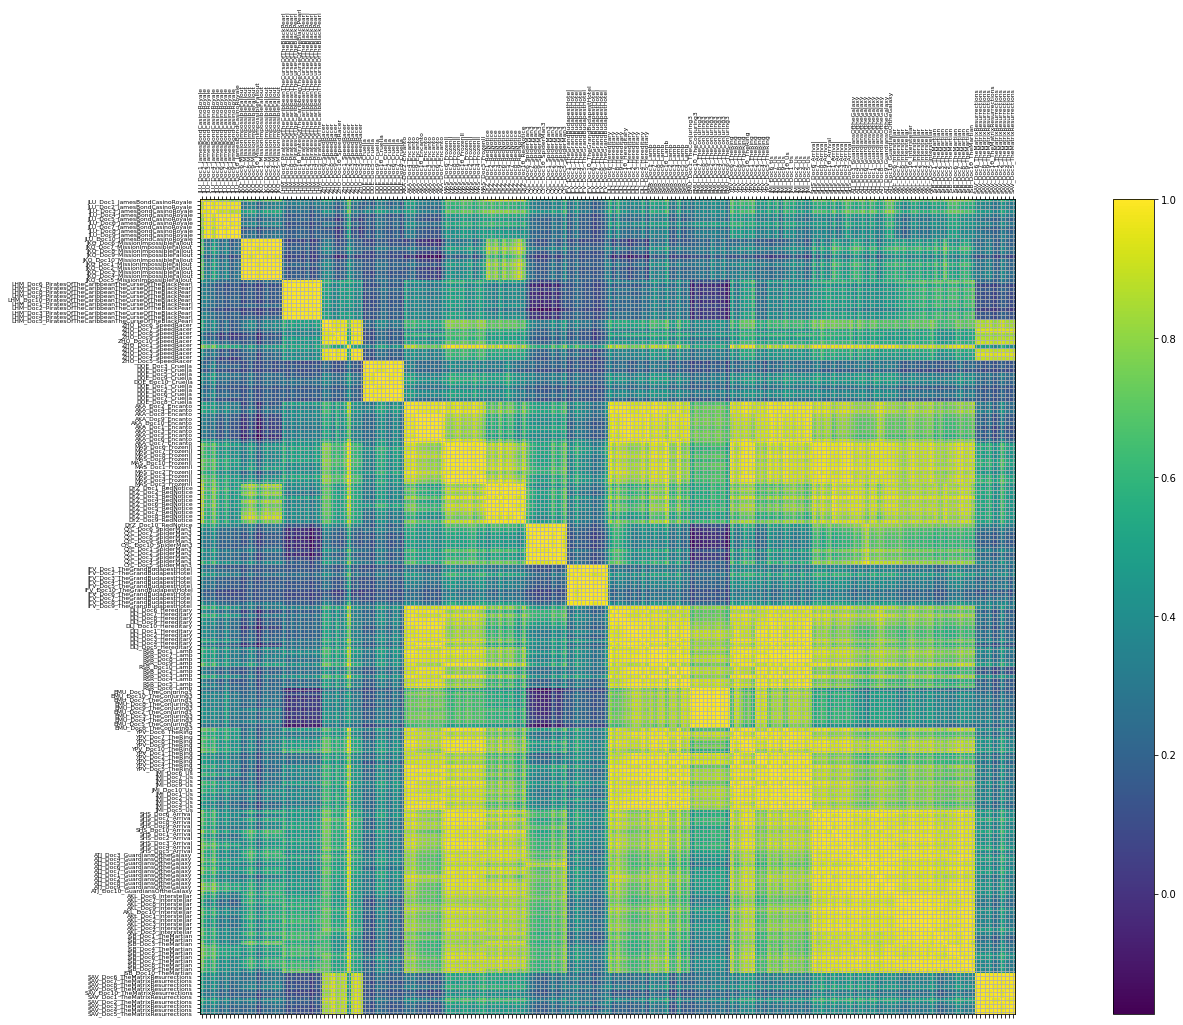

In [37]:
model_8topic_10words = plot_lsa(8, 10)

### Test: 10 topics 10 words

[(0, '-0.247*"character" + -0.163*"cruella" + -0.155*"first" + -0.133*"scene" + -0.130*"would" + -0.128*"world" + -0.128*"action" + -0.125*"never" + -0.121*"anderson" + -0.114*"thing"'), (1, '0.751*"cruella" + 0.163*"estella" + 0.159*"baroness" + 0.148*"stone" + -0.137*"anderson" + 0.123*"fashion" + 0.123*"thompson" + 0.110*"villain" + 0.090*"character" + -0.090*"matrix"'), (2, '-0.477*"anderson" + -0.292*"budapest" + -0.285*"grand" + -0.276*"hotel" + -0.202*"gustave" + 0.164*"mission" + -0.152*"andersonõs" + 0.131*"action" + 0.120*"impossible" + 0.114*"cruise"'), (3, '-0.287*"mission" + -0.260*"impossible" + -0.254*"cruise" + -0.228*"action" + -0.224*"fallout" + 0.223*"family" + -0.222*"matrix" + 0.166*"horror" + -0.149*"mcquarrie" + -0.126*"anderson"'), (4, '-0.496*"matrix" + -0.226*"speed" + -0.215*"resurrection" + 0.200*"casino" + 0.200*"royale" + 0.194*"vesper" + -0.168*"wachowski" + -0.168*"racer" + 0.153*"mission" + 0.118*"impossible"'), (5, '0.328*"casino" + 0.323*"royale" + 0.

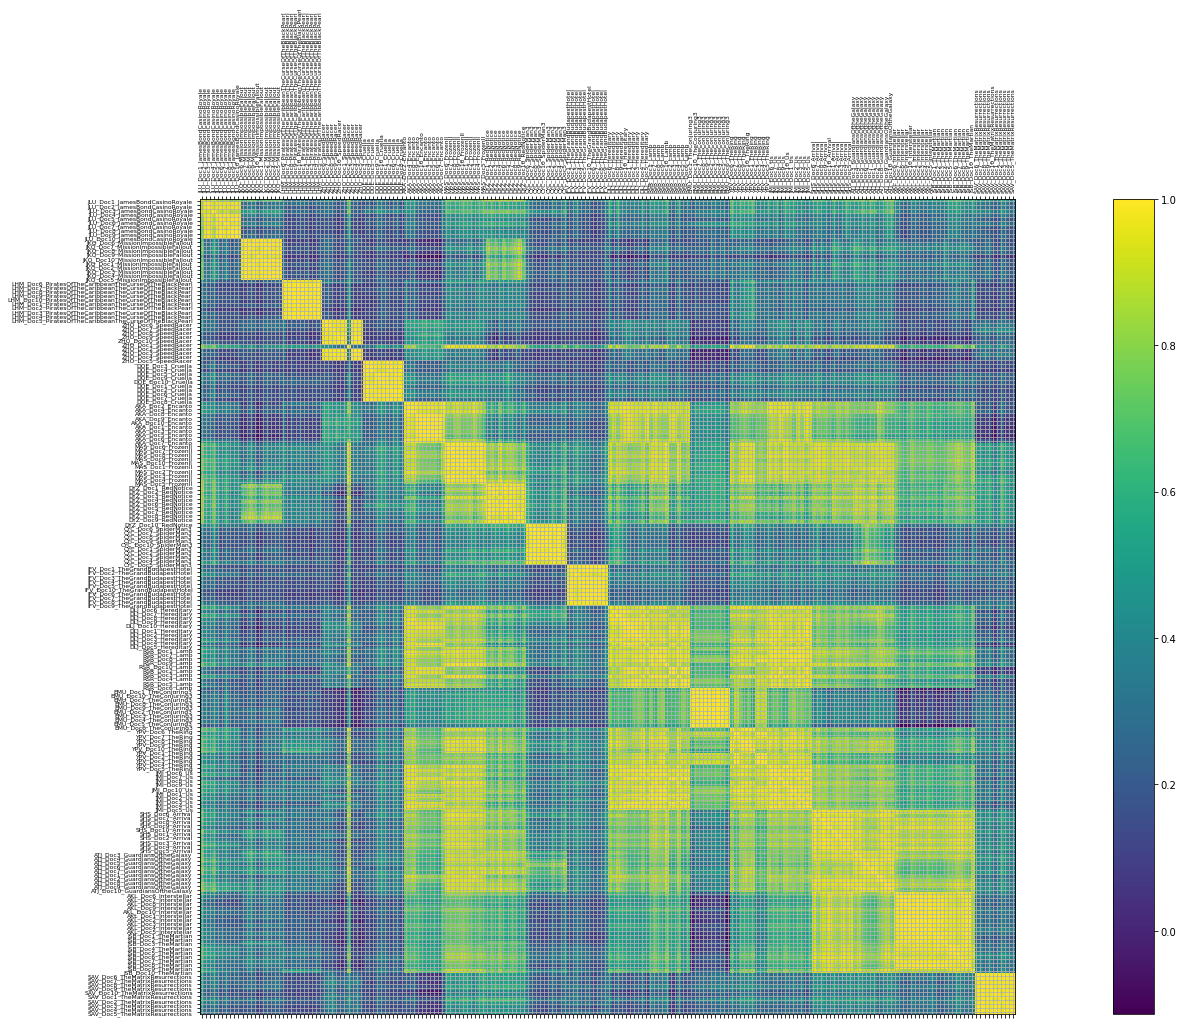

In [38]:
model_10topic_10words =plot_lsa(10, 10)

### Plotting 20 topics and 10 words

[(0, '-0.247*"character" + -0.163*"cruella" + -0.155*"first" + -0.133*"scene" + -0.130*"would" + -0.128*"world" + -0.128*"action" + -0.125*"never" + -0.121*"anderson" + -0.114*"thing"'), (1, '0.751*"cruella" + 0.163*"estella" + 0.159*"baroness" + 0.148*"stone" + -0.137*"anderson" + 0.123*"fashion" + 0.123*"thompson" + 0.111*"villain" + 0.090*"character" + -0.090*"matrix"'), (2, '0.477*"anderson" + 0.292*"budapest" + 0.285*"grand" + 0.276*"hotel" + 0.202*"gustave" + -0.164*"mission" + 0.152*"andersonõs" + -0.131*"action" + -0.120*"impossible" + -0.114*"cruise"'), (3, '-0.287*"mission" + -0.260*"impossible" + -0.254*"cruise" + -0.228*"action" + -0.224*"fallout" + 0.223*"family" + -0.222*"matrix" + 0.166*"horror" + -0.149*"mcquarrie" + -0.126*"anderson"'), (4, '0.496*"matrix" + 0.226*"speed" + 0.215*"resurrection" + -0.200*"casino" + -0.200*"royale" + -0.194*"vesper" + 0.168*"wachowski" + 0.167*"racer" + -0.153*"mission" + -0.118*"impossible"'), (5, '-0.328*"casino" + -0.323*"royale" + -0

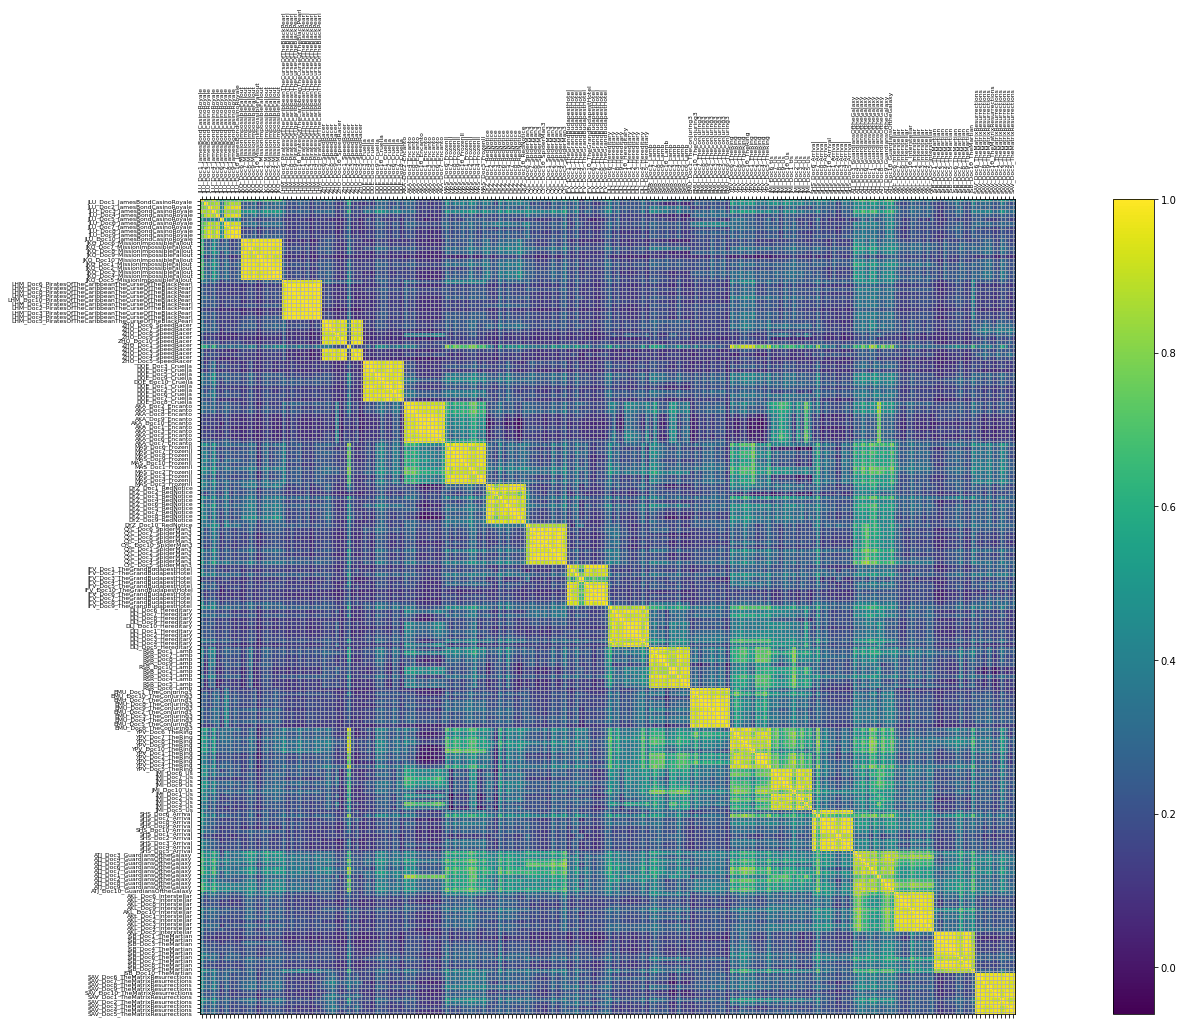

In [39]:
model_20topic_10words =plot_lsa(20, 10)

### Compare LSA Model Coherence

In [40]:
topics = [2, 4, 6, 8, 10, 20]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'2 topic 10 words': coherence_values[0],
            '4 topic 10 words':coherence_values[1],
            '6 topic 10 words':coherence_values[2],
            '8 topic 10 words': coherence_values[3],
            '10 topic 10 words': coherence_values[4],
            '20 topic 10 words': coherence_values[5]}   

coherence

# Coherence = score a single topic by measuring the degree of semantic similarity between high scoring words in the topic
# Highest: 4 topics/10 words (0.431) and 6 topics/10 words (0.408)

[(0, '0.247*"character" + 0.163*"cruella" + 0.155*"first" + 0.133*"scene" + 0.130*"would" + 0.128*"world" + 0.128*"action" + 0.125*"never" + 0.121*"anderson" + 0.114*"thing"'), (1, '-0.751*"cruella" + -0.163*"estella" + -0.159*"baroness" + -0.148*"stone" + 0.137*"anderson" + -0.123*"fashion" + -0.123*"thompson" + -0.110*"villain" + -0.090*"character" + 0.090*"matrix"')]
[(0, '0.247*"character" + 0.163*"cruella" + 0.155*"first" + 0.133*"scene" + 0.130*"would" + 0.128*"world" + 0.128*"action" + 0.125*"never" + 0.121*"anderson" + 0.114*"thing"'), (1, '-0.751*"cruella" + -0.163*"estella" + -0.159*"baroness" + -0.148*"stone" + 0.137*"anderson" + -0.123*"fashion" + -0.123*"thompson" + -0.110*"villain" + -0.090*"character" + 0.090*"matrix"'), (2, '0.477*"anderson" + 0.292*"budapest" + 0.285*"grand" + 0.276*"hotel" + 0.202*"gustave" + -0.164*"mission" + 0.152*"andersonõs" + -0.131*"action" + -0.120*"impossible" + -0.114*"cruise"'), (3, '-0.287*"mission" + -0.260*"impossible" + -0.254*"cruise" 

{'10 topic 10 words': 0.46054044716951487,
 '2 topic 10 words': 0.23923946432480658,
 '20 topic 10 words': 0.46649979910494055,
 '4 topic 10 words': 0.39087814472672266,
 '6 topic 10 words': 0.4890127151139543,
 '8 topic 10 words': 0.47570683055402113}

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [41]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
##number_of_topics=10
##words=6
##iterations = 200
#####################################

[(0, '0.004*"character" + 0.004*"thing" + 0.004*"could" + 0.004*"anderson" + 0.004*"really" + 0.004*"something"'), (1, '0.003*"character" + 0.003*"scene" + 0.003*"pirate" + 0.003*"action" + 0.003*"point" + 0.003*"first"'), (2, '0.005*"character" + 0.004*"horror" + 0.003*"spiderman" + 0.003*"first" + 0.003*"family" + 0.003*"never"'), (3, '0.003*"pirate" + 0.003*"peter" + 0.003*"world" + 0.003*"spiderman" + 0.002*"though" + 0.002*"might"'), (4, '0.004*"would" + 0.004*"family" + 0.004*"something" + 0.003*"people" + 0.003*"character" + 0.003*"thing"'), (5, '0.006*"cruella" + 0.005*"character" + 0.004*"pirate" + 0.003*"grand" + 0.003*"budapest" + 0.003*"world"'), (6, '0.005*"cruella" + 0.004*"character" + 0.002*"anderson" + 0.002*"speed" + 0.002*"matrix" + 0.002*"little"'), (7, '0.005*"first" + 0.004*"character" + 0.003*"casino" + 0.003*"scene" + 0.003*"mission" + 0.003*"matrix"'), (8, '0.005*"family" + 0.004*"character" + 0.004*"speed" + 0.004*"matrix" + 0.003*"first" + 0.003*"horror"'), (

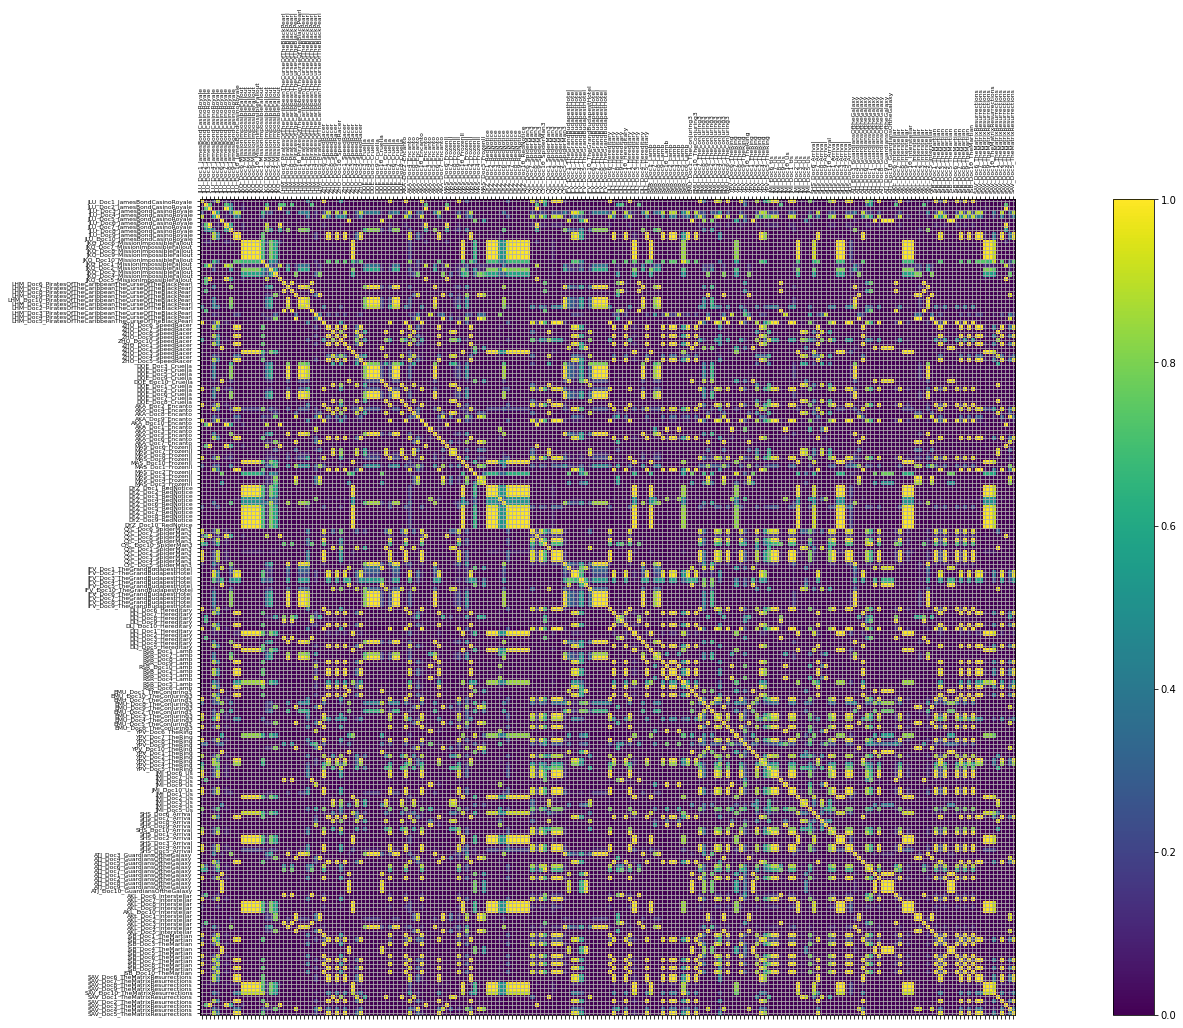

In [42]:
## model2, dictionary2, index2, doctermmatrix2 = create_gensim_lda_model(processed_text, number_of_topics, words, iterations)

model2, dictionary2, index2, doctermmatrix2 = create_gensim_lda_model(processed_text, 10, 6, 200)


for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(35 , 15))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90, fontsize = 6);
plt.yticks(range(len(processed_text)), titles, fontsize = 6);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [43]:
topics = [2, 4, 6, 8, 10, 20]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10, 200)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'2 topic 10 words': coherence_values[0],
            '4 topic 10 words':coherence_values[1],
            '6 topic 10 words':coherence_values[2],
            '8 topic 10 words': coherence_values[3],
            '10 topic 10 words': coherence_values[4],
            '20 topic 10 words': coherence_values[5]}  

coherence

# Coherence = score a single topic by measuring the degree of semantic similarity between high scoring words in the topic
# All are about the same
# Highest: 20 topics/10 words (0.251) 

[(0, '0.005*"character" + 0.003*"scene" + 0.003*"action" + 0.002*"would" + 0.002*"family" + 0.002*"first" + 0.002*"moment" + 0.002*"never" + 0.002*"something" + 0.002*"though"'), (1, '0.004*"first" + 0.003*"character" + 0.003*"horror" + 0.003*"family" + 0.003*"thing" + 0.003*"world" + 0.003*"matrix" + 0.003*"would" + 0.002*"cruella" + 0.002*"action"')]
[(0, '0.003*"character" + 0.003*"world" + 0.002*"mission" + 0.002*"would" + 0.002*"first" + 0.002*"scene" + 0.002*"family" + 0.002*"thing" + 0.002*"interstellar" + 0.002*"human"'), (1, '0.005*"character" + 0.003*"first" + 0.003*"family" + 0.003*"horror" + 0.003*"franchise" + 0.003*"moment" + 0.002*"scene" + 0.002*"mission" + 0.002*"would" + 0.002*"action"'), (2, '0.004*"character" + 0.003*"anderson" + 0.003*"family" + 0.003*"action" + 0.003*"first" + 0.003*"thing" + 0.003*"would" + 0.003*"cruella" + 0.003*"never" + 0.003*"world"'), (3, '0.005*"character" + 0.004*"first" + 0.003*"cruella" + 0.003*"pirate" + 0.003*"horror" + 0.002*"would" 

{'10 topic 10 words': 0.2320169144086673,
 '2 topic 10 words': 0.2609953852106087,
 '20 topic 10 words': 0.23537429370561616,
 '4 topic 10 words': 0.23463593212927547,
 '6 topic 10 words': 0.2345324727938253,
 '8 topic 10 words': 0.2445232879044576}